In [12]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

## Getting the data

To get the data, either run `gather.py` located in root folder, or add the data manually to the `data` folder.

## Optimization:

### Currently, all yearly dataset consume a lot of memory:
**for example, 1987 alone weighs 484 MB.**

1) check largest number in all datasets and columns to downscale numeric columns. Done by the `get_maxes` function in `load.py` module.
> *after viewing function output,it is confirmed that all numeric columns of all yearly datasets fit into `float32` dtype.*

2. convert relevant columns to categorical(done by `get_years` function in `load.py` module

### *NOTE - initally planned to just use unsampled datasets, but visualization operations are taking way too long.*

3. sample each year seperately for even weight, then concatenate selected years, then sample again.

In [74]:
from load import get_years, wipe_frames
#More info and demonstration within module.

## Exploration

In [48]:
def drop_outliers(data, value_col, p=5, category_col=None):
    """Return DataFrame without overflow values."""
    def trunc(frame):  
        top, bottom = np.nanpercentile(a=frame[value_col], q=[100 - p / 2, p / 2])
        return frame[(frame[value_col] >= bottom) & (frame[value_col] <= top)].copy()
    if category_col:
        if data[category_col].dtype != 'category':
            raise TypeError('Category_col dtype should be categorical.')
        objs = [trunc(data[data[category_col] == item]) for item in data[category_col].cat.categories]
        return pd.concat(objs, ignore_index=True)
    else:
        return trunc(data)

In [49]:
df = get_years(year_range=(2000, 2008)) # loads about ~3mins, but final dataset is very light.

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1198 to 4266
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   UniqueCarrier      1000 non-null   category
 1   Year               1000 non-null   category
 2   Month              1000 non-null   category
 3   DayOfMonth         1000 non-null   category
 4   DayOfWeek          1000 non-null   category
 5   Cancelled          1000 non-null   boolean 
 6   ArrDelay           982 non-null    float32 
 7   DepDelay           983 non-null    float32 
 8   Diverted           1000 non-null   boolean 
 9   Origin             1000 non-null   category
 10  Dest               1000 non-null   category
 11  ActualElapsedTime  982 non-null    float32 
 12  AirTime            982 non-null    float32 
 13  Distance           1000 non-null   float32 
dtypes: boolean(2), category(7), float32(5)
memory usage: 53.2 KB


In [51]:
def drop_outliers(data, value_col, p=5, category_col=None):
    """Return DataFrame without overflow values."""
    def trunc(frame):  
        top, bottom = np.nanpercentile(a=frame[value_col], q=[100 - p / 2, p / 2])
        return frame[(frame[value_col] >= bottom) & (frame[value_col] <= top)].copy()
    if category_col:
        if data[category_col].dtype != 'category':
            raise TypeError('Category_col dtype should be categorical.')
        objs = [trunc(data[data[category_col] == item]) for item in data[category_col].cat.categories]
        return pd.concat(objs, ignore_index=True)
    else:
        return trunc(data)

### 1. Distribution of departure delays in for each unique carrier in 1987

<AxesSubplot: xlabel='UniqueCarrier', ylabel='DepDelay'>

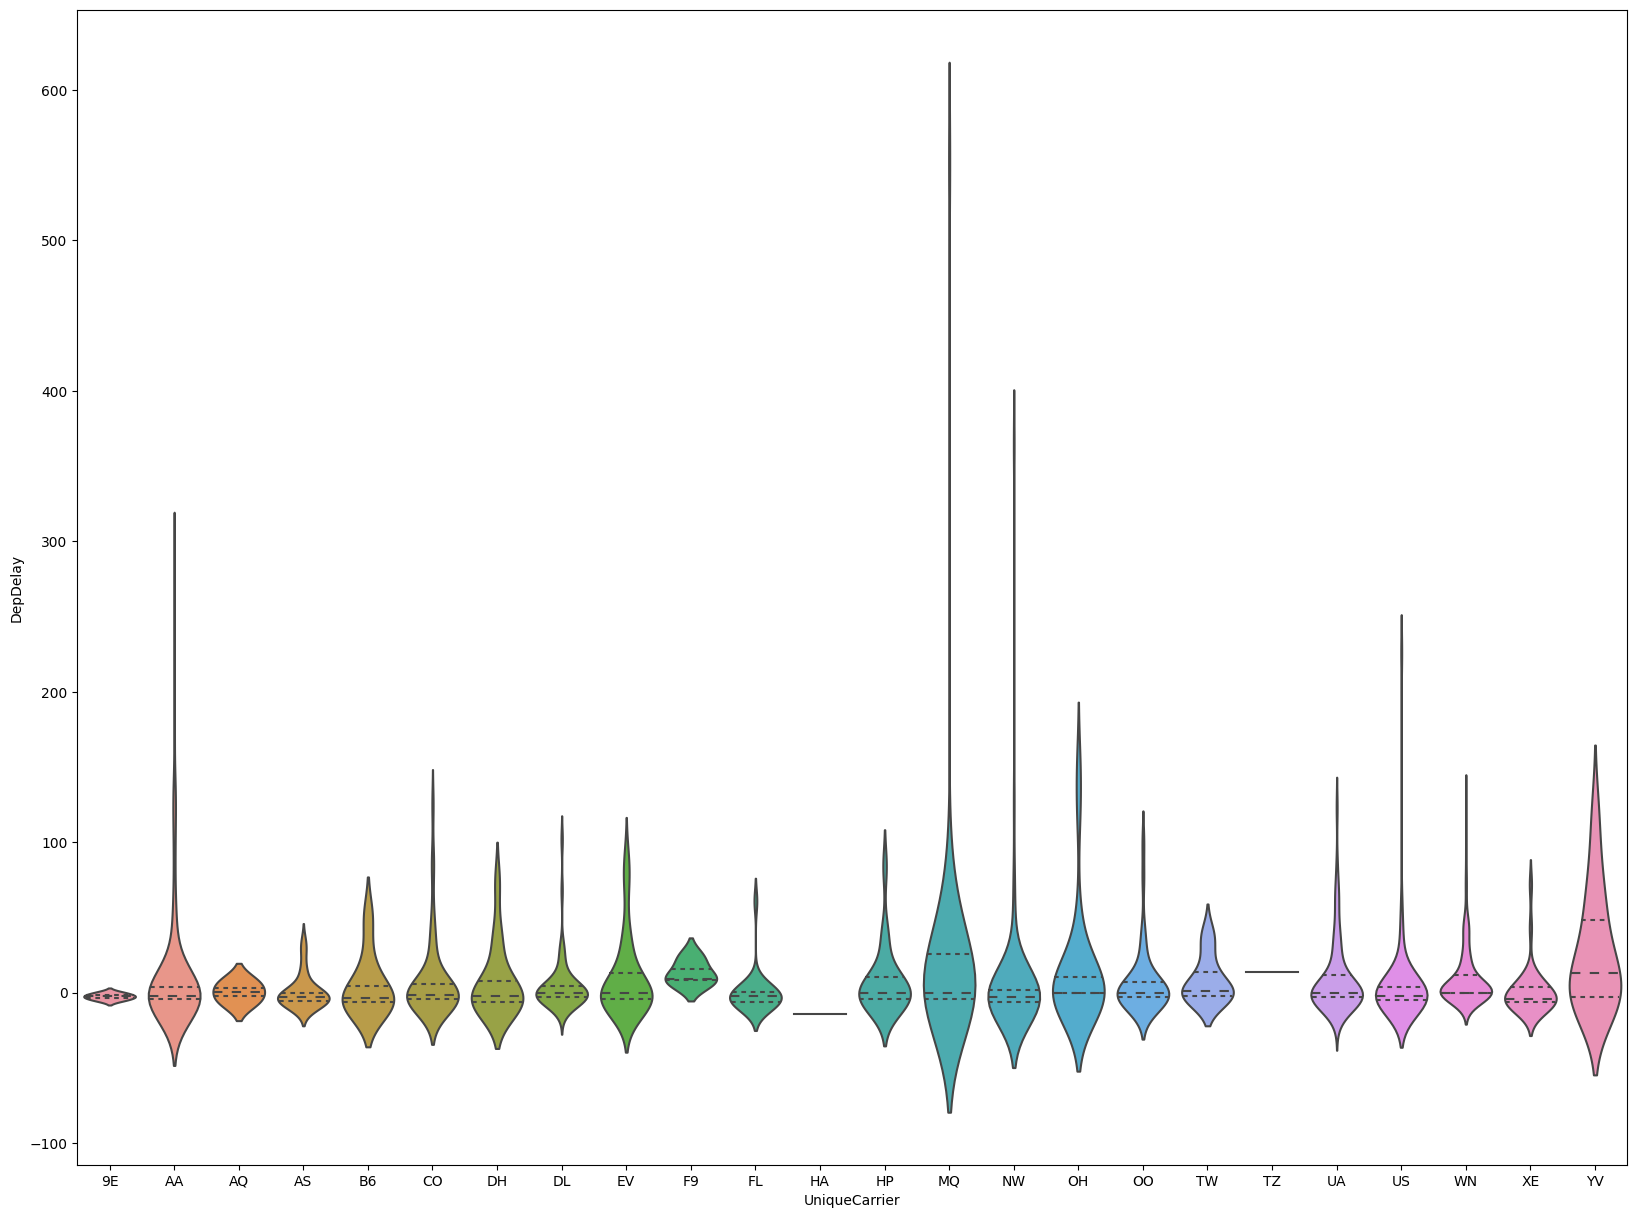

In [52]:
fig, ax = plt.subplots(figsize=(20, 15))
sns.violinplot(data=df, x='UniqueCarrier', y='DepDelay', inner='quartile', scale='width')

### 2. Distribution of departure delay combined with arrival delay (%95 data)

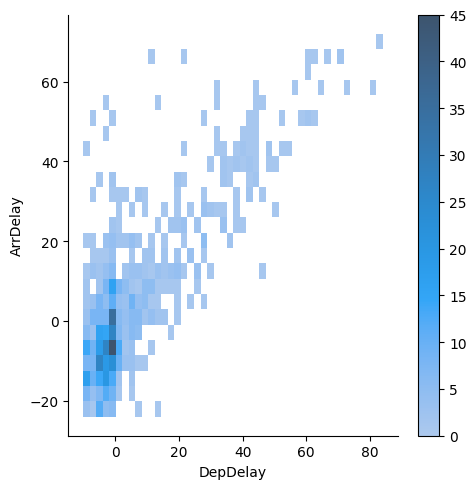

In [70]:
clean_data = drop_outliers(drop_outliers(df, 'DepDelay'), 'ArrDelay')
sns.displot(data=clean_data, x='DepDelay', y='ArrDelay', cbar=True)

### 3. Percentage of diverted flights for each origin-dest pair

In [83]:
grouped_df = df.groupby(by = ['Origin'])
grouped_df.sum()

,Cancelled,ArrDelay,DepDelay,Diverted,ActualElapsedTime,AirTime,Distance
Origin,,,,,,,
ABQ,0,6.0,7.0,0,431.0,376.0,2989.0
ACV,0,-7.0,-10.0,0,137.0,107.0,457.0
ALB,0,-53.0,-13.0,0,357.0,325.0,2115.0
AMA,0,-6.0,-1.0,0,55.0,43.0,277.0
ANC,0,2.0,-7.0,0,281.0,247.0,2125.0
...,...,...,...,...,...,...,...
TUS,0,56.0,34.0,0,717.0,613.0,4921.0
TVC,0,0.0,15.0,0,117.0,82.0,431.0
TYS,0,12.0,-8.0,0,230.0,188.0,998.0
